<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Desafio 4 - Rodrigues da Cruz (a2123)

El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder. Cada fila tiene una frase en inglés, su traducción al español y algo de información extra que no usamos. La idea es quedarnos solo con dos listas limpias de frases alineadas, una en inglés y otra en español, para entrenar después el modelo encoder–decoder.


In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
from torchinfo import summary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [5]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, epochs=15, pad_index=0):
    device = next(model.parameters()).device

    criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    for epoch in range(epochs):
        # ------------------ TRAIN ------------------
        model.train()
        epoch_train_loss = 0.0
        correct_tokens = 0
        total_tokens = 0

        for encoder_input, decoder_input, target_onehot in train_loader:
            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            target_onehot = target_onehot.to(device)  # (B, T, V)

            # one-hot -> índices (B, T)
            target_idx = target_onehot.argmax(dim=-1)

            optimizer.zero_grad()

            # logits: (B, T, V)
            outputs = model(encoder_input, decoder_input)

            B, T, V = outputs.shape
            outputs_flat = outputs.view(B * T, V)
            targets_flat = target_idx.view(B * T)

            loss = criterion(outputs_flat, targets_flat)
            loss.backward()

            # pequeño clipping para evitar explosión de gradientes
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_train_loss += loss.item()

            with torch.no_grad():
                preds_flat = outputs_flat.argmax(dim=-1)
                mask = targets_flat != pad_index
                correct_tokens += (preds_flat[mask] == targets_flat[mask]).sum().item()
                total_tokens += mask.sum().item()

        epoch_train_loss /= len(train_loader)
        epoch_train_acc = correct_tokens / max(total_tokens, 1)
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # ------------------ VALID ------------------
        model.eval()
        epoch_valid_loss = 0.0
        correct_tokens = 0
        total_tokens = 0

        with torch.no_grad():
            for encoder_input, decoder_input, target_onehot in valid_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target_onehot = target_onehot.to(device)

                target_idx = target_onehot.argmax(dim=-1)

                outputs = model(encoder_input, decoder_input)

                B, T, V = outputs.shape
                outputs_flat = outputs.view(B * T, V)
                targets_flat = target_idx.view(B * T)

                loss = criterion(outputs_flat, targets_flat)
                epoch_valid_loss += loss.item()

                preds_flat = outputs_flat.argmax(dim=-1)
                mask = targets_flat != pad_index
                correct_tokens += (preds_flat[mask] == targets_flat[mask]).sum().item()
                total_tokens += mask.sum().item()

        epoch_valid_loss /= len(valid_loader)
        epoch_valid_acc = correct_tokens / max(total_tokens, 1)

        valid_loss_history.append(epoch_valid_loss)
        valid_acc_history.append(epoch_valid_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"loss: {epoch_train_loss:.3f} - acc: {epoch_train_acc:.3f} | "
            f"val_loss: {epoch_valid_loss:.3f} - val_acc: {epoch_valid_acc:.3f}"
        )

    history = {
        "loss": train_loss_history,
        "accuracy": train_acc_history,
        "val_loss": valid_loss_history,
        "val_accuracy": valid_acc_history,
    }
    return history


### 1 - Datos

In [6]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [7]:
import numpy as np
from collections import defaultdict, Counter

text_file = "C:/Users/n.rodrigues.da.cruz/Downloads/spa-eng/spa-eng/spa.txt"
with open(text_file, encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

print("Cantidad de rows disponibles en el archivo:", len(lines))

# Relajamos cantidad de datos (más que 6000)
MAX_NUM_SENTENCES = 20000  

np.random.seed(40)
np.random.shuffle(lines)

raw_input_sentences = []
raw_output_sentences = []
raw_output_sentences_inputs = []

for line in lines:
    if "\t" not in line:
        continue

    input_sentence, output = line.rstrip().split("\t")

    output_sentence = output + " <eos>"
    output_sentence_input = "<sos> " + output

    raw_input_sentences.append(input_sentence)
    raw_output_sentences.append(output_sentence)
    raw_output_sentences_inputs.append(output_sentence_input)

    if len(raw_input_sentences) >= MAX_NUM_SENTENCES:
        break

print("Original número de oraciones (antes de balancear):", len(raw_input_sentences))

# --- EDA rápida de comienzos (opcional, pero útil para comentar en el TP) ---

start_bigrams = Counter()
for out in raw_output_sentences:
    text = out.replace("<eos>", "").strip().lower()
    tokens = text.split()
    if len(tokens) == 0:
        continue
    bigram = " ".join(tokens[:2]) if len(tokens) >= 2 else tokens[0]
    start_bigrams[bigram] += 1

print("\nTop 15 bigrams iniciales:")
for w, c in start_bigrams.most_common(15):
    print(f"{w:25s} {c}")

# --- Balanceo por bigrama inicial ---

MAX_PER_START = 300  # máximo de ejemplos por bigrama de inicio

start_to_indices = defaultdict(list)
for idx, out in enumerate(raw_output_sentences):
    text = out.replace("<eos>", "").strip().lower()
    tokens = text.split()
    if len(tokens) == 0:
        continue
    bigram = " ".join(tokens[:2]) if len(tokens) >= 2 else tokens[0]
    start_to_indices[bigram].append(idx)

selected_indices = []

for bigram, idxs in start_to_indices.items():
    if len(idxs) <= MAX_PER_START:
        selected_indices.extend(idxs)
    else:
        # tomamos una muestra al azar de tamaño MAX_PER_START
        chosen = np.random.choice(idxs, size=MAX_PER_START, replace=False)
        selected_indices.extend(chosen)

# Nos aseguramos de no repetir índices y los ordenamos
selected_indices = sorted(set(selected_indices))

print("\nNúmero de oraciones tras balancear por inicio:", len(selected_indices))

input_sentences = [raw_input_sentences[i] for i in selected_indices]
output_sentences = [raw_output_sentences[i] for i in selected_indices]
output_sentences_inputs = [raw_output_sentences_inputs[i] for i in selected_indices]

print("Cantidad de rows utilizadas finalmente:", len(input_sentences))
print("\nEjemplo 1:")
print("  EN     :", input_sentences[0])
print("  ES real:", output_sentences[0])
print("  dec_in :", output_sentences_inputs[0])


Cantidad de rows disponibles en el archivo: 118964
Original número de oraciones (antes de balancear): 20000

Top 15 bigrams iniciales:
tom no                    377
tom se                    189
¿por qué                  181
tom es                    162
no me                     135
creo que                  125
por favor,                105
no quiero                 99
tom está                  92
él es                     91
tom le                    91
tom y                     88
no puedo                  87
él se                     76
pensé que                 73

Número de oraciones tras balancear por inicio: 19923
Cantidad de rows utilizadas finalmente: 19923

Ejemplo 1:
  EN     : Somebody stole my car.
  ES real: Alguien robó mi auto. <eos>
  dec_in : <sos> Alguien robó mi auto.


In [8]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('Somebody stole my car.',
 'Alguien robó mi auto. <eos>',
 '<sos> Alguien robó mi auto.')

Acá miramos un ejemplo para ver si el preprocesamiento tiene sentido.  
`input_sentences` guarda la oración original en inglés, `output_sentences` es la traducción en español y `output_sentences_inputs` es la versión “corrida” que empieza con el token `<sos>`.  
Esta versión corrida es la que va leyendo el decodificador durante el entrenamiento, palabra por palabra.


### 2 - Preprocesamiento

In [9]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 10000

In [10]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 6806
Sentencia de entrada más larga: 34


In [11]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 11310
Sentencia de salida más larga: 43


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

Longitudes de las oraciones (tokens)
  Input  - min: 1, max: 34, media: 6.33, mediana: 6.00
  Output - min: 1, max: 43, media: 7.03, mediana: 7.00
  Percentil 50% -> input: 6.0 tokens, output: 7.0 tokens
  Percentil 75% -> input: 8.0 tokens, output: 8.0 tokens
  Percentil 90% -> input: 10.0 tokens, output: 11.0 tokens
  Percentil 95% -> input: 11.0 tokens, output: 12.0 tokens
  Percentil 99% -> input: 15.0 tokens, output: 16.0 tokens


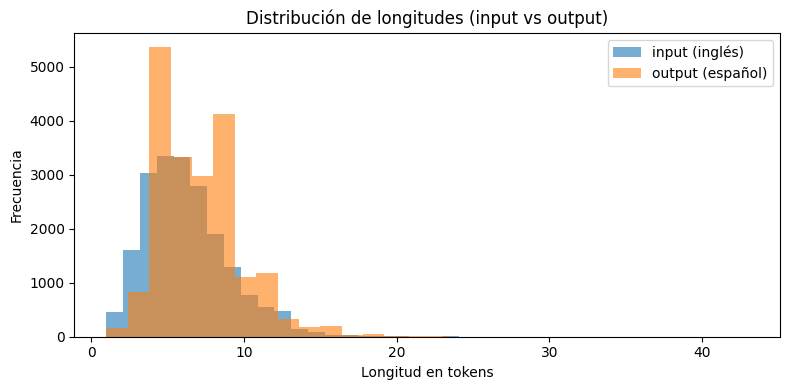

max_input_len: 10
max_out_len: 11
max_input_len elegido (95% de las oraciones): 10
max_out_len elegido (95% de las oraciones): 11


In [12]:
# Longitudes de secuencias en tokens (antes de padding)
input_lengths = np.array([len(seq) for seq in input_integer_seq])
output_lengths = np.array([len(seq) for seq in output_integer_seq])

print("Longitudes de las oraciones (tokens)")
print(f"  Input  - min: {input_lengths.min()}, max: {input_lengths.max()}, "
      f"media: {input_lengths.mean():.2f}, mediana: {np.median(input_lengths):.2f}")
print(f"  Output - min: {output_lengths.min()}, max: {output_lengths.max()}, "
      f"media: {output_lengths.mean():.2f}, mediana: {np.median(output_lengths):.2f}")

for p in [50, 75, 90, 95, 99]:
    in_p = np.percentile(input_lengths, p)
    out_p = np.percentile(output_lengths, p)
    print(f"  Percentil {p:>2}% -> input: {in_p:.1f} tokens, output: {out_p:.1f} tokens")

plt.figure(figsize=(8, 4))
plt.hist(input_lengths, bins=30, alpha=0.6, label="input (inglés)")
plt.hist(output_lengths, bins=30, alpha=0.6, label="output (español)")
plt.xlabel("Longitud en tokens")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes (input vs output)")
plt.legend()
plt.tight_layout()
plt.show()

# Elegir nuevas longitudes máximas menos restrictivas usando percentil 95
max_input_len = int(np.percentile(input_lengths, 90))
max_out_len   = int(np.percentile(output_lengths, 90))

# Tope razonable (relajado respecto al TP, pero no extremo)
max_input_len = min(max_input_len, 20)
max_out_len   = min(max_out_len, 22)

print("max_input_len:", max_input_len)
print("max_out_len:", max_out_len)


print(f"max_input_len elegido (95% de las oraciones): {max_input_len}")
print(f"max_out_len elegido (95% de las oraciones): {max_out_len}")


Estas estadísticas nos ayudan a elegir longitudes máximas razonables para hacer el padding.   Mirando los percentiles vemos qué tan largas son la mayoría de las oraciones y podemos ignorar solo los casos extremos.   Usar el percentil 95 es un buen compromiso: mantenemos casi todas las oraciones sin hacerlas demasiado largas, lo que ahorra memoria y acelera el entrenamiento.

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [13]:
import numpy as np

def pad_sequences(
    sequences,
    maxlen,
    dtype="int32",
    padding="pre",
    truncating="pre",
    value=0
):
    """
    Versión simple de pad_sequences compatible con NumPy 2.0.
    Solo cubre el caso de secuencias numéricas (que es lo que usamos acá).
    """
    num_samples = len(sequences)
    x = np.full((num_samples, maxlen), value, dtype=dtype)

    for i, seq in enumerate(sequences):
        if seq is None:
            continue
        seq = list(seq)

        if not len(seq):
            continue

        # Truncar
        if truncating == "pre":
            trunc = seq[-maxlen:]
        elif truncating == "post":
            trunc = seq[:maxlen]
        else:
            raise ValueError("truncating debe ser 'pre' o 'post'")

        trunc = np.asarray(trunc, dtype=dtype)

        # Padding
        if padding == "pre":
            x[i, -len(trunc):] = trunc
        elif padding == "post":
            x[i, :len(trunc)] = trunc
        else:
            raise ValueError("padding debe ser 'pre' o 'post'")

    return x


In [14]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 19923
encoder_input_sequences shape: (19923, 10)
decoder_input_sequences shape: (19923, 11)


In [15]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (19923, 11)


La función `pad_sequences` hace que todas las secuencias tengan el mismo largo agregando tokens de relleno (ceros).   Hacer el padding al final (`padding='post'`) mantiene el orden de las palabras reales y deja el relleno al final.  Esto es importante porque el modelo aprende que el cero significa “no hay palabra” y se concentra en la parte útil de cada secuencia.


In [16]:
print("encoder_input_sequences max index:", encoder_input_sequences.max())
print("decoder_input_sequences max index:", decoder_input_sequences.max())

input_vocab_size = int(encoder_input_sequences.max()) + 1
output_vocab_size = int(decoder_input_sequences.max()) + 1

print("input_vocab_size real:", input_vocab_size)
print("output_vocab_size real:", output_vocab_size)


encoder_input_sequences max index: 6806
decoder_input_sequences max index: 9999
input_vocab_size real: 6807
output_vocab_size real: 10000


Los tamaños reales de vocabulario nos dicen cuántos IDs de tokens diferentes necesitamos en las capas de embedding.   Sumamos 1 al índice máximo porque el índice 0 lo reservamos para el padding.   Con estos valores definimos el tamaño de las tablas que convierten cada ID de token en un vector denso (embedding).

La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategía que se transformó la entrada del decoder.

In [17]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([19923, 11])

In [18]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 10
decoder_input_size: 11
Output dim 10000


In [19]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 15939
Tamaño del conjunto de validacion: 3984


Acá envolvemos los arrays de NumPy en un df de PyTorch para que el modelo pueda iterar en mini-batches.   También separamos los datos en un conjunto de entrenamiento y otro de validación.   El conjunto de entrenamiento sirve para ajustar los pesos del modelo y el de validación para ver qué tan bien generaliza a ejemplos que no vio durante el entrenamiento.


### 3 - Preparar los embeddings

In [20]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [21]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [22]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [23]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 80


En este paso preparamos la matriz de embeddings para el vocabulario en inglés usando vectores GloVe pre-entrenados.   Si una palabra existe en GloVe, copiamos su vector a la matriz; si no, se queda con un vector de ceros.   Esto le da al modelo un buen punto de partida, porque muchas palabras ya vienen con información semántica aprendida de un corpus grande.


In [24]:
nb_words

6806

In [25]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(6806, 50)

### 4 - Entrenar el modelo

In [ ]:
import torch
import torch.nn as nn

# usá el mismo embed_dim que ya venías usando (por ej. 100 o 300)
# si en tu notebook se llama distinto, respetá ese nombre
embedding_dim = embed_dim  # si tu variable es embed_dim

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_input, decoder_input):
        device = encoder_input.device

        batch_size = encoder_input.size(0)
        decoder_input_len = decoder_input.size(1)
        vocab_size = self.decoder.output_dim

        # IMPORTANTE: outputs en el mismo device
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=device)

        # estado inicial del decoder = estado final del encoder
        prev_state = self.encoder(encoder_input)

        # primer token del decoder (normalmente <sos>)
        input_step = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            logits, prev_state = self.decoder(input_step, prev_state)
            outputs[:, t, :] = logits
            # teacher forcing: siguiente entrada es el token real
            input_step = decoder_input[:, t:t+1]

        return outputs  # shape: (B, T, V) con LOGITS
    

class EncoderMid(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 128        # en vez de 256
        self.num_layers = 1         # una sola capa
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=0.0,
        )

    def forward(self, x):
        out = self.embedding(x)
        _, (ht, ct) = self.lstm(out)
        return (ht, ct)


class DecoderMid(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=0.0,
        )
        self.fc1 = nn.Linear(self.lstm_size, self.output_dim)

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        logits = self.fc1(lstm_output[:, -1, :])
        return logits, (ht, ct)



La arquitectura es un modelo clásico de secuencia a secuencia basado en LSTMs.   El encoder lee toda la oración en inglés y la resume en un estado oculto.   El decoder usa ese estado para generar la traducción al español, token por token.  Usamos una sola capa LSTM y un tamaño de estado oculto más chico para tener un modelo liviano y rápido de entrenar, pero que igual pueda manejar oraciones cortas.


In [27]:
input_vocab_size  = int(encoder_input_sequences.max()) + 1
output_vocab_size = int(decoder_input_sequences.max()) + 1

encoder_mid = EncoderMid(vocab_size=input_vocab_size)
decoder_mid = DecoderMid(vocab_size=output_vocab_size, output_dim=output_vocab_size)

if cuda:
    encoder_mid.cuda()
    decoder_mid.cuda()

model_mid = Seq2Seq(encoder_mid, decoder_mid)
if cuda:
    model_mid.cuda()

optimizer_mid = torch.optim.Adam(model_mid.parameters(), lr=0.001)

history_mid = train(
    model_mid,
    train_loader,
    valid_loader,
    optimizer_mid,
    epochs=10,
    pad_index=0
)


Epoch 1/10 | loss: 6.145 - acc: 0.175 | val_loss: 5.521 - val_acc: 0.204
Epoch 2/10 | loss: 5.469 - acc: 0.222 | val_loss: 5.175 - val_acc: 0.240
Epoch 3/10 | loss: 5.057 - acc: 0.256 | val_loss: 4.907 - val_acc: 0.266
Epoch 4/10 | loss: 4.683 - acc: 0.283 | val_loss: 4.716 - val_acc: 0.285
Epoch 5/10 | loss: 4.348 - acc: 0.306 | val_loss: 4.580 - val_acc: 0.297
Epoch 6/10 | loss: 4.040 - acc: 0.323 | val_loss: 4.489 - val_acc: 0.303
Epoch 7/10 | loss: 3.755 - acc: 0.339 | val_loss: 4.416 - val_acc: 0.312
Epoch 8/10 | loss: 3.484 - acc: 0.355 | val_loss: 4.368 - val_acc: 0.317
Epoch 9/10 | loss: 3.238 - acc: 0.374 | val_loss: 4.346 - val_acc: 0.322
Epoch 10/10 | loss: 3.007 - acc: 0.395 | val_loss: 4.329 - val_acc: 0.323


La función train corre varias épocas sobre el conjunto de entrenamiento y actualiza los parámetros del modelo con el optimizador Adam.  Al final de cada época también evalúa el modelo en el conjunto de validación y guarda la historia de accuracy.  Esa historia la usamos después para graficar cómo cambian el accuracy de entrenamiento y de validación a lo largo de las épocas.

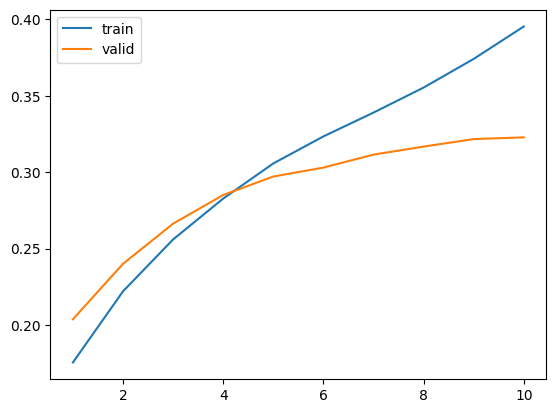

In [28]:
epoch_count = range(1, len(history_mid['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_mid['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_mid['val_accuracy'], label='valid')
plt.show()

Este gráfico nos muestra si el modelo realmente está aprendiendo.  Esperamos que el accuracy de entrenamiento y de validación vaya subiendo con las épocas.  Si el accuracy de entrenamiento es mucho más alto que el de validación, el modelo puede estar sobreajustando. Pequeñas diferencias con los resultados de la notebook original son normales y pueden deberse a la inicialización aleatoria, a versiones distintas de librerías o al hardware.


### 5 - Inferencia

In [29]:
# Conversores de índice a palabra
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

device = torch.device("cuda" if cuda else "cpu")

def translate_sentence(model, sentence, max_len=max_out_len):
    model.eval()

    # Texto → ids
    integer_seq = input_tokenizer.texts_to_sequences([sentence])[0]
    encoder_seq = pad_sequences([integer_seq], maxlen=max_input_len)
    encoder_tensor = torch.from_numpy(encoder_seq.astype(np.int32)).to(device)

    # Estado inicial del decoder desde el encoder
    prev_state = model.encoder(encoder_tensor)

    # Token inicial <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs["<sos>"]
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32)).to(device)

    eos = word2idx_outputs["<eos>"]
    output_sentence = []

    for _ in range(max_len):
        output, prev_state = model.decoder(target_seq_tensor, prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        if idx == eos:
            break

        if idx > 0:
            word = idx2word_target.get(idx, "")
            if word:
                output_sentence.append(word)

        # re-alimentar el token predicho
        target_seq_tensor = top1.to(device)

    return " ".join(output_sentence)


In [ ]:
# Ejemplos manuales
test_sentences = [
    "How are you?",
    "My mother says hi.",
    "I like to learn machine learning.",
    "This restaurant is very good.",
    "I will call you tomorrow."
]

print("=== Traducciones===")
for s in test_sentences:
    print("-" * 50)
    print("EN:", s)
    print("ES:", translate_sentence(model_mid, s))

# Ejemplos tomados del dataset (para comparar con la referencia)
print("\n=== Ejemplos del dataset ===")
for _ in range(5):
    i = np.random.randint(len(input_sentences))
    src = input_sentences[i]
    tgt = output_sentences[i]
    pred = translate_sentence(model_mid, src)
    print("-" * 50)
    print("EN      :", src)
    print("ES real :", tgt)
    print("ES pred :", pred)


=== Traducciones (modelo grande) ===
--------------------------------------------------
EN: How are you?
ES: ¡qué estás
--------------------------------------------------
EN: My mother says hi.
ES: mi no que en habitación
--------------------------------------------------
EN: I like to learn machine learning.
ES: me a a gusta los de
--------------------------------------------------
EN: This restaurant is very good.
ES: este es buena muy
--------------------------------------------------
EN: I will call you tomorrow.
ES: te a mañana mañana

=== Ejemplos del dataset ===
--------------------------------------------------
EN      : We haven't been called to the meeting yet.
ES real : Todavía no nos han citado para la reunión. <eos>
ES pred : no estado de el de que la de
--------------------------------------------------
EN      : She's my older sister.
ES real : Ella es mi hermana mayor. <eos>
ES pred : ella mi es de padre mi
--------------------------------------------------
EN      : Ev

Estos ejemplos nos dan una idea cualitativa de cómo traduce el modelo.  Las oraciones cortas y simples suelen salir mejor, mientras que las más largas o con estructuras raras muestran más errores.  Esto indica que el modelo funciona como una prueba de concepto básica y que podría mejorar con más datos, un tamaño de estado oculto mayor, mecanismos de atención o más épocas de entrenamiento.
